<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/01_gradient_descent_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gradient Descent Fundamentals

In this notebook we will start by looking at the Linear Regression model, one of the simplest models there is. We will discuss two very different ways to train it:

- Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).
- Using an iterative optimization approach called Gradient Descent (GD) that
gradually tweaks the model parameters to minimize the cost function over the
training set, eventually converging to the same set of parameters as the first
method.


##Setup

In [26]:
# Common imports
import numpy as np
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##Normal Equation

To find the value of $\theta$ that minimizes the cost function, there is a closed-form solution —in other words, a mathematical equation that gives the result directly. This is called the Normal Equation.

$$\hat\theta = (X^TX)^{-1}X^Ty $$

Where:
- $\hat\theta$ is the value of $\theta$ that minimizes the cost function
- $y$ is the vector of target values containing $y^{(i)}$ to $y^{(m)}$

Let’s generate some linear-looking data(100 sample only) to test this equation.

In [27]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [28]:
X.shape, y.shape

((100, 1), (100, 1))

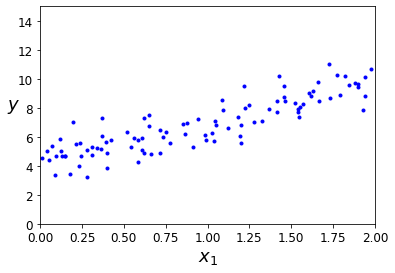

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Now let’s compute $\theta$ using the Normal Equation. We will use the `inv()` function from NumPy’s linear algebra module (`np.linalg`) to compute the inverse of a matrix, and the `dot()` method for matrix multiplication:

In [30]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The function that we used to generate the data is $y = 4 + 3x_1$ + Gaussian noise.

In [31]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 4.215$ and $\theta_1 = 2.770$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using $\hat\theta$.

In [32]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_pred = X_new_b.dot(theta_best)
y_pred

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions.

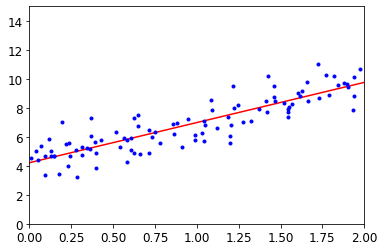

In [33]:
plt.plot(X_new, y_pred, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

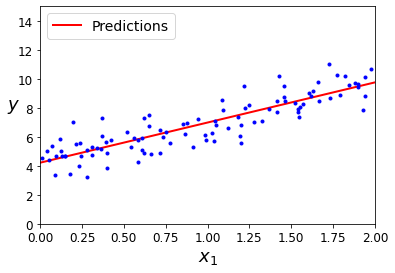

In [34]:
plt.plot(X_new, y_pred, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple.

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [36]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The LinearRegression class is based on the `scipy.linalg.lstsq()` function (the
name stands for “least squares”), which you could call directly:

In [37]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\theta = X^+y$, where $X^+$ is the pseudoinverse of X (specifically, the Moore-Penrose inverse). 

You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [38]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **Singular Value Decomposition(SVD)** that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $UΣ V^⊺$. The pseudoinverse is computed as $X^+ = VΣ^+U^⊺$.

This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix $X^⊺X$ is not invertible (i.e., singular), such as if $m < n$ or if some
features are redundant, but the pseudoinverse is always defined.

##Computational Complexity

The Normal Equation computes the inverse of $X^⊺X$, which is an $(n + 1) × (n + 1)$ matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. 

In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

The SVD approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4.

>Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regard to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), predictions are very fast.

So we need different way to train a Linear Regression model, which is
better suited for cases where there are a large number of features or too many training instances to fit in memory.

And it could be achieved by **Gradient Descent**.

##Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions
to a wide range of problems. The general idea of Gradient Descent is to tweak
parameters iteratively in order to minimize a cost function.

And the fact that training a model means searching for a combination of model parameters that minimizes a cost function.

###Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function
with regard to each model parameter $\theta_j$. In other words, you need to calculate
how much the cost function will change if you change $\theta_j$ just a little bit. This is called
a partial derivative. 

It is like asking “What is the slope of the mountain under my feet
if I face east?” and then asking the same question facing north (and so on for all other
dimensions, if you can imagine a universe with more than three dimensions).

We computes the partial derivative of the cost function with regard to parameter
$\theta_j$.

$
\dfrac{\partial}{\partial \theta_j} \text{MSE}(\boldsymbol{\theta}) =
\dfrac{1}{m}\sum\limits_{i=1}^{m} \dfrac{\partial}{\partial \theta_j} (\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})^2
$

$
\space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space =\dfrac{2}{m}\sum\limits_{i=1}^{m}(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})\, \dfrac{\partial}{\partial \theta_j} (\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})
$

$\space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space=\dfrac{2}{m}\sum\limits_{i=1}^{m}(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})\, \dfrac{\partial}{\partial \theta_j} (\boldsymbol{\theta}^T \mathbf{x}^{(i)}) - \dfrac{\partial}{\partial \theta_j} (y^{(i)})
$

$\space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space=\dfrac{2}{m}\sum\limits_{i=1}^{m}(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})\, x_j^{(i)}
$

Instead of computing these partial derivatives individually, you can to compute them all in one go. The gradient vector, noted $\nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta})$, contains all the
partial derivatives of the cost function (one for each model parameter).

$$
\nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) =
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\boldsymbol{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\boldsymbol{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\boldsymbol{\theta})
\end{pmatrix}
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$$

Notice that this formula involves calculations over the full training
set X, at each Gradient Descent step! This is why the algorithm is
called Batch Gradient Descent: it uses the whole batch of training
data at every step (actually, Full Gradient Descent would probably
be a better name).

As a result it is terribly slow on very large training
sets.However, Gradient Descent scales well with the number of
features; training a Linear Regression model when there are hundreds
of thousands of features is much faster using Gradient
Descent than using the Normal Equation or SVD decomposition.

Once you have the gradient vector, which points uphill, just go in the opposite direction
to go downhill. This means subtracting $\nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta})$ from $\theta$. This is where the
learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the size of the downhill step.

$$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta}^{\text{current step}} - \eta \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta})
$$

Let’s look at a quick implementation of this algorithm:


In [39]:
theta_path_bgd = []

# learning rate
eta = 0.1
n_iterations = 1000
m = 100

# random initialization of weights
theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients
  theta_path_bgd.append(theta)

That wasn’t too hard! Let’s look at the resulting theta:

In [40]:
theta

array([[4.21509616],
       [2.77011339]])

In [41]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

Hey, that’s exactly what the Normal Equation found! Gradient Descent worked perfectly.

Gradient Descent worked perfectly.
But what if you had used a different learning rate eta?

In [42]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

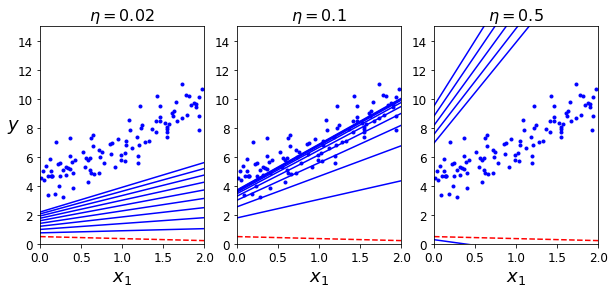

In [43]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

On the left, the learning rate is too low: the algorithm will eventually reach the solution,
but it will take a long time. In the middle, the learning rate looks pretty good: in
just a few iterations, it has already converged to the solution. On the right, the learning
rate is too high: the algorithm diverges, jumping all over the place and actually
getting further and further away from the solution at every step.

To find a good learning rate, you can use grid search.However, you
may want to limit the number of iterations so that grid search can eliminate models
that take too long to converge.

You may wonder how to set the number of iterations. If it is too low, you will still be
far away from the optimal solution when the algorithm stops; but if it is too high, you
will waste time while the model parameters do not change anymore.

A simple solution
is to set a very large number of iterations but to interrupt the algorithm when the
gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny
number $ϵ$ (called the tolerance)—because this happens when Gradient Descent has
(almost) reached the minimum.


###Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when the training set is large.

At the opposite extreme, Stochastic Gradient Descent picks a
random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration.

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much
less regular than Batch Gradient Descent: instead of gently decreasing until it reaches
the minimum, the cost function will bounce up and down, decreasing only on average.
Over time it will end up very close to the minimum, but once it gets there it will
continue to bounce around, never settling down. So once the algorithm
stops, the final parameter values are good, but not optimal.

When the cost function is very irregular, this can actually help the
algorithm jump out of local minima, so Stochastic Gradient Descent has a better
chance of finding the global minimum than Batch Gradient Descent does.

Therefore, randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate.

The function that determines the learning rate at each
iteration is called the learning schedule.

Let's implements Stochastic Gradient Descent using a simple learning schedule:

In [44]:
theta_path_sgd = []

n_epochs = 50
t0, t1 = 5, 50                 # learning schedule hyperparameters
theta = np.random.randn(2, 1)  # random initialization

def learning_schedule(t):
  return t0 / (t + t1)


for epoch in range(n_epochs):   # first loop on epoch
  for i in range(m):            # second loop on m dataset(100)
    random_index = np.random.randint(m)
    # slide over dataset one row at a time
    xi = X_b[random_index: random_index + 1]
    yi = y[random_index: random_index + 1]
    # calculate gradient
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + 1)
    theta = theta - eta * gradients
    theta_path_sgd.append(theta)

By convention we iterate by rounds of m iterations; each round is called an epoch.

In [45]:
theta

array([[4.20725458],
       [2.7418767 ]])

Let's shows the first 20 steps of training (notice how irregular the steps are).

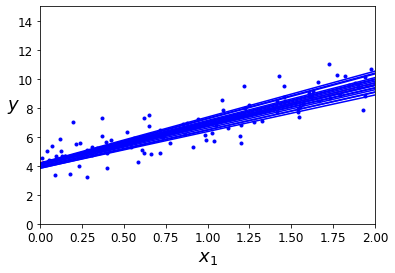

In [46]:
np.random.seed(42)

for epoch in range(n_epochs):   # first loop on epoch
  for i in range(m):            # second loop on m dataset(100)
    if epoch == 0 and i < 20:
      y_pred = X_new_b.dot(theta)
      style = "b-" if i > 0 else "r--"
      plt.plot(X_new, y_pred, style)
    random_index = np.random.randint(m)
    # slide over dataset one row at a time
    xi = X_b[random_index: random_index + 1]
    yi = y[random_index: random_index + 1]
    # calculate gradient
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + 1)
    theta = theta - eta * gradients
plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                         
plt.show()

Note that since instances are picked randomly, some instances may be picked several
times per epoch, while others may not be picked at all.

When using Stochastic Gradient Descent, the training instances
must be independent and identically distributed (IID) to ensure
that the parameters get pulled toward the global optimum, on average.

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the
SGDRegressor class, which defaults to optimizing the squared error cost function.

In [47]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

Once again, you find a solution quite close to the one returned by the Normal
Equation:

In [48]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.15989071]), array([2.73186613]))

###Mini-batch Gradient Descent

Instead of computing the gradients based on the full training set
(as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. 

The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance
boost from hardware optimization of matrix operations, especially when using
GPUs.


In [49]:
np.random.seed(42)

theta_path_mgd = []
n_epochs = 50
minibatch_size = 20

t0, t1 = 200, 1000             # learning schedule hyperparameters
theta = np.random.randn(2, 1)  # random initialization

def learning_schedule(t):
  return t0 / (t + t1)

t = 0
for epoch in range(n_epochs):   # first loop on epoch
  # shuffle the batch
  shuffled_indices = np.random.permutation(m)
  X_b_shuffled = X_b[shuffled_indices]
  y_shuffled = y[shuffled_indices]
  for i in range(0, m, minibatch_size):            # second loop on m dataset as per minibatch_size(20)
    t += 1
    random_index = np.random.randint(m)
    # slide over dataset based on minibatch size
    xi = X_b_shuffled[i: i + minibatch_size]
    yi = y_shuffled[i: i + minibatch_size]
    # calculate gradient
    gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(t)
    theta = theta - eta * gradients
    theta_path_mgd.append(theta)

In [50]:
theta

array([[4.20712935],
       [2.78497579]])

Now, let's take a look on all these gradient-based method.

In [51]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

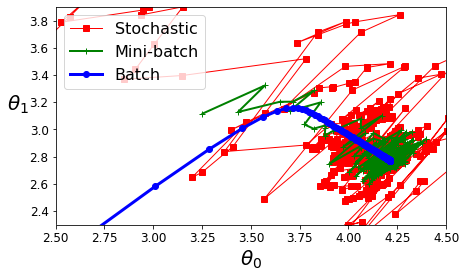

In [52]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

They all end up near the minimum, but Batch GD’s path actually stops at the minimum, while both Stochastic
GD and Mini-batch GD continue to walk around. 

However, don’t forget that Batch
GD takes a lot of time to take each step, and Stochastic GD and Mini-batch GD
would also reach the minimum if you used a good learning schedule.

**While the Normal Equation can only perform Linear Regression, the Gradient Descent algorithms can be used to train many other models.**